In [92]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from pathlib import Path
import holidays


In [2]:
BASE_DIR = Path(os.getcwd()).parent.parent
data_path = Path(os.path.join(f"{BASE_DIR}","backend","data","processed","CLEAN_MERGED_DATASET.csv"))
merged_data = pd.read_csv(data_path)
merged_data['date'] = pd.to_datetime(merged_data['date'])

In [7]:
print(merged_data.head())

   Unnamed: 0.1                date     load  Unnamed: 0  temperature_2m  \
0             0 2023-09-01 00:00:00  22602.0           0       26.489000   
1             1 2023-09-01 01:00:00  21934.0           1       26.088999   
2             2 2023-09-01 02:00:00  20796.0           2       25.289000   
3             3 2023-09-01 03:00:00  19475.0           3       25.239000   
4             4 2023-09-01 04:00:00  17492.0           4       25.239000   

   relative_humidity_2m  apparent_temperature  precipitation  pressure_msl  \
0              90.94568             32.514164            0.1        1013.0   
1              93.67663             32.000885            0.0        1013.6   
2              97.64485             31.533634            0.0        1014.7   
3              96.48432             31.321900            2.0        1015.1   
4              97.06265             31.376713            0.1        1015.3   

   cloud_cover  cloud_cover_low  cloud_cover_mid  cloud_cover_high  \
0   

TEMPORAL PATTERNS 

In [10]:
merged_data['Hour'] = merged_data['date'].dt.hour
merged_data['Time_Period'] = merged_data['Hour'].apply(lambda x: 'Day' if (x >= 7) and (x < 19) else 'Night')

day_night_use = merged_data.groupby('Time_Period')['load'].mean()
print(day_night_use)

Time_Period
Day      14986.121417
Night    18153.207759
Name: load, dtype: float64


In [13]:
merged_data['Month'] = merged_data['date'].dt.month
load_by_hour_month = merged_data.pivot_table(
    values='load',
    index='Hour',
    columns='Month',
    aggfunc='mean'
)
print(load_by_hour_month.head())
    
    

Month          1.0           2.0           3.0           4.0           5.0   \
Hour                                                                          
0.0    16088.645161  15960.649123  16627.344262  18673.300000  22372.754098   
1.0    15877.193548  15832.543860  16448.209677  18208.833333  21561.508197   
2.0    15333.387097  15117.719298  15600.145161  17233.766667  20521.819672   
3.0    14586.403226  14254.070175  14537.258065  15851.483333  19022.901639   
4.0    13665.274194  13219.017544  13214.290323  14248.283333  17421.032787   

Month          6.0           7.0           8.0           9.0           10.0  \
Hour                                                                          
0.0    22572.440678  23617.290323  23521.322581  22069.065574  19372.822581   
1.0    21771.728814  22774.370968  22819.338710  21404.316667  18624.483871   
2.0    20929.949153  21871.774194  21785.596774  20247.616667  17565.790323   
3.0    19605.288136  20503.532258  20360.612903  18

<function matplotlib.pyplot.show(close=None, block=None)>

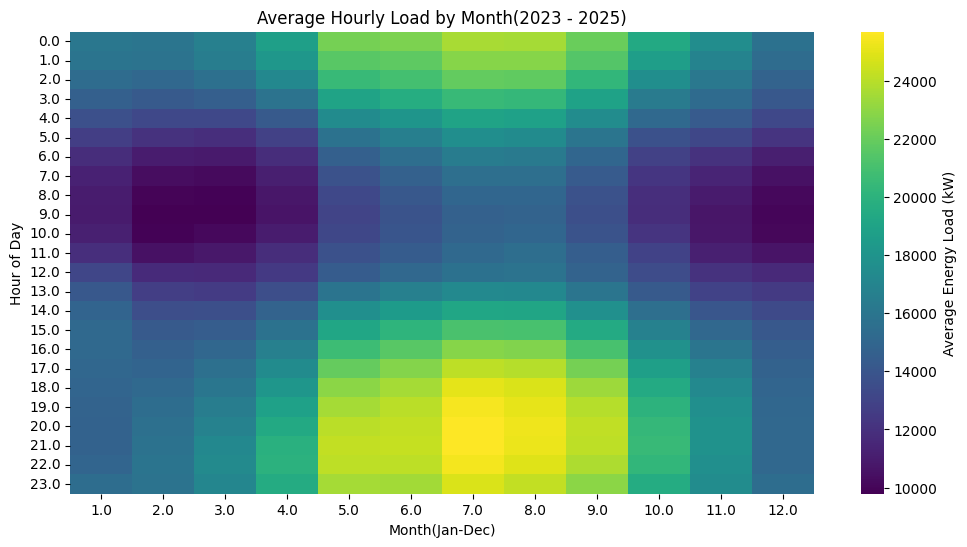

In [15]:
plt.figure(figsize = (12,6))
sns.heatmap(
    load_by_hour_month,
    cmap='viridis',
    annot=False,
    cbar_kws={'label': 'Average Energy Load (kW)'}
)
plt.title('Average Hourly Load by Month(2023 - 2025)')
plt.xlabel('Month(Jan-Dec)')
plt.ylabel('Hour of Day')
plt.show
          

In [24]:
merged_data['Week_Type'] = merged_data['date'].dt.dayofweek.map(lambda x: 'Weekend' if x >= 5 else 'Weekday')
load_by_day_type = merged_data.pivot_table(
    values = 'load',
    index = 'Hour',
    columns = 'Week_Type',
    aggfunc = 'mean'
)
print(load_by_day_type)

Week_Type       Weekday       Weekend
Hour                                 
0.0        19684.884170  19154.363636
1.0        19158.492248  18533.442857
2.0        18270.172481  17717.871429
3.0        17049.683495  16750.823810
4.0        15673.035019  15623.919048
5.0        14309.179337  14415.693780
6.0        13234.226306  13397.209524
7.0        12542.394584  12669.641148
8.0        12129.707930  12184.452381
9.0        12003.375242  11905.823810
10.0       12304.725338  11855.885714
11.0       13038.642166  12024.523810
12.0       13869.427466  12519.638095
13.0       14965.303675  13831.104762
14.0       16206.907157  15499.081340
15.0       17331.978723  16911.166667
16.0       18302.684720  18014.919048
17.0       19077.622824  18879.290476
18.0       19699.947776  19493.638095
19.0       20108.825919  19860.680952
20.0       20368.092843  20070.176190
21.0       20495.802708  20113.585714
22.0       20411.657640  19970.014286
23.0       20102.292070  19566.100000


<function matplotlib.pyplot.show(close=None, block=None)>

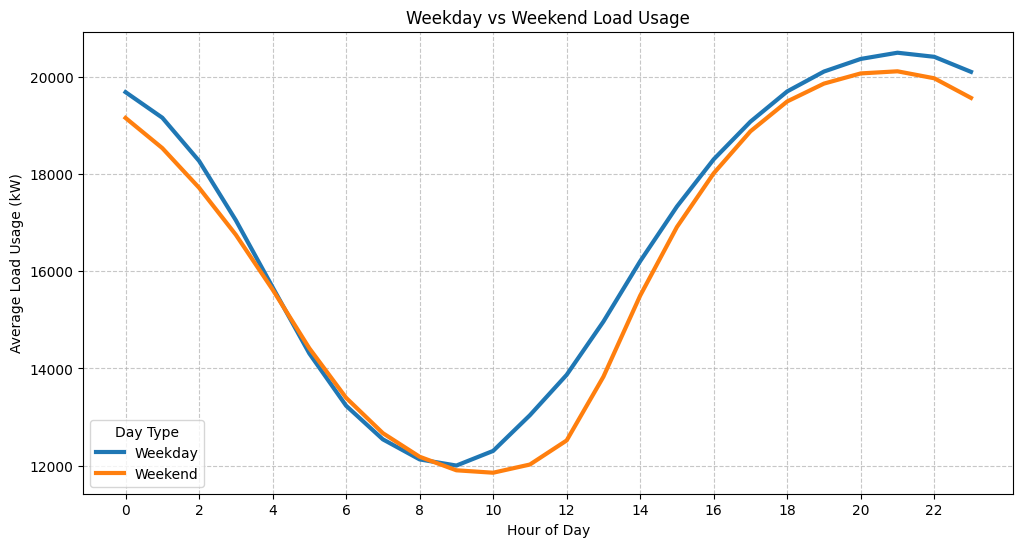

In [26]:
plt.figure(figsize = (12,6))

load_by_day_type.plot(ax=plt.gca(), linewidth = 3)
plt.title('Weekday vs Weekend Load Usage')
plt.xlabel('Hour of Day')
plt.ylabel('Average Load Usage (kW)')
plt.legend(title='Day Type')
plt.xticks(range(0,24,2))
plt.grid(True, linestyle = '--', alpha=0.7)
plt.show

Load vs Cloud Cover & Sunshine

In [50]:
correlation_matrix = merged_data[['sunshine_duration','cloud_cover','load']].corr()
print(correlation_matrix)

                   sunshine_duration  cloud_cover      load
sunshine_duration           1.000000    -0.097616  0.599196
cloud_cover                -0.097616     1.000000  0.083664
load                        0.599196     0.083664  1.000000


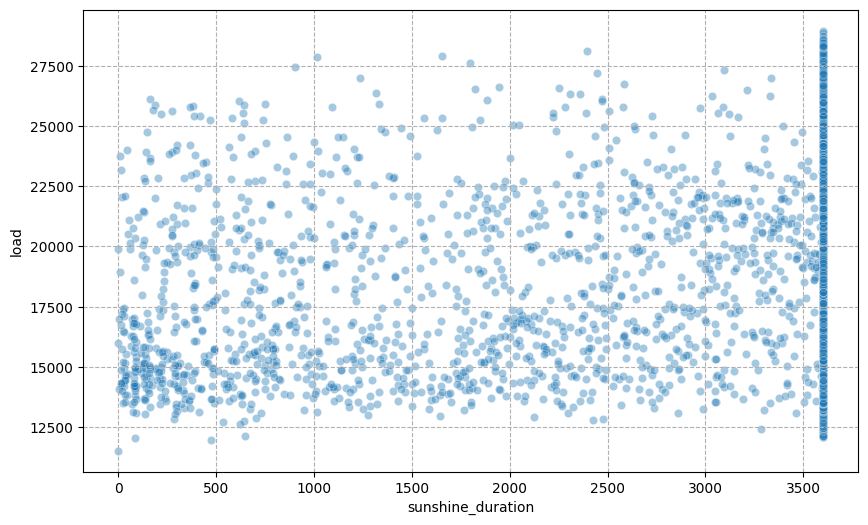

In [85]:
sunlight_hours = merged_data[merged_data['sunshine_duration'] > 0].copy()

plt.figure(figsize=(10,6))
sns.scatterplot(
    x='sunshine_duration',
    y='load',
    data=sunlight_hours,
    alpha=0.4
)
plt.grid(True, linestyle='--')

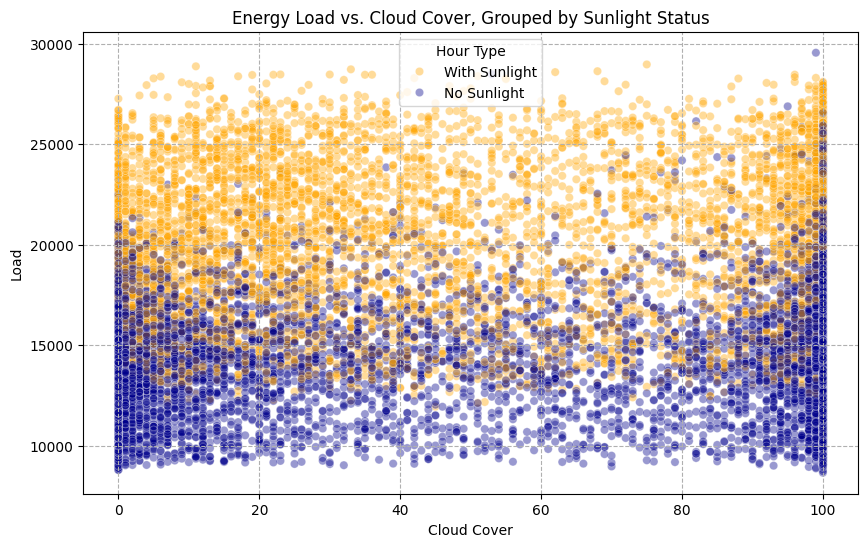

In [88]:
merged_data['Sunlight_Status'] = merged_data['sunshine_duration'].apply(
    lambda x: 'With Sunlight' if x > 0 else 'No Sunlight'
)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='cloud_cover',
    y='load',
    hue='Sunlight_Status',
    data=merged_data,
    alpha=0.4,
    palette={'With Sunlight': 'orange', 'No Sunlight': 'darkblue'}
)
plt.title('Energy Load vs. Cloud Cover, Grouped by Sunlight Status')
plt.xlabel('Cloud Cover')
plt.ylabel('Load')
plt.legend(title='Hour Type')
plt.grid(True, linestyle='--')


Precipitation Effects

In [74]:
merged_data['is_rainy'] = merged_data['precipitation'].apply(lambda x : 'Rainy Hour' if x > 0 else 'Non Rainy')

comparison = merged_data.groupby('is_rainy')['load'].agg(['count','mean','median','std'])
print(comparison.sort_values(by='mean', ascending=False))

            count          mean   median          std
is_rainy                                             
Rainy Hour   2487  19528.948130  19815.0  4715.359157
Non Rainy   14947  16076.216164  15282.0  4168.390126


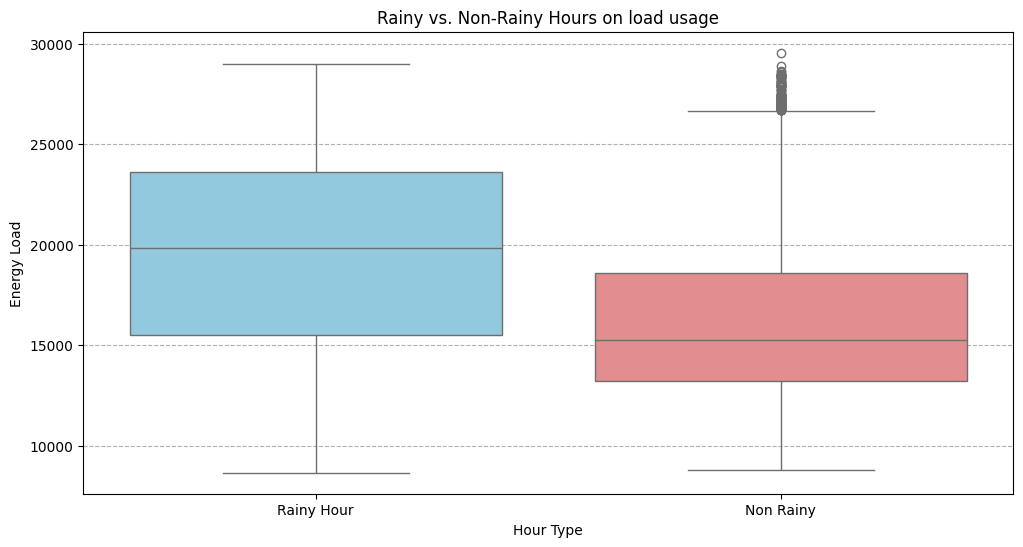

In [86]:
plt.figure(figsize=(12,6))
sns.boxplot(
    x = 'is_rainy',
    y = 'load',
    hue='is_rainy',
    data=merged_data,
    palette={'Rainy Hour': 'skyblue', 'Non Rainy': 'lightcoral'}   
)
plt.title("Rainy vs. Non-Rainy Hours on load usage")
plt.xlabel('Hour Type')
plt.ylabel('Energy Load')
plt.grid(axis='y', linestyle='--')

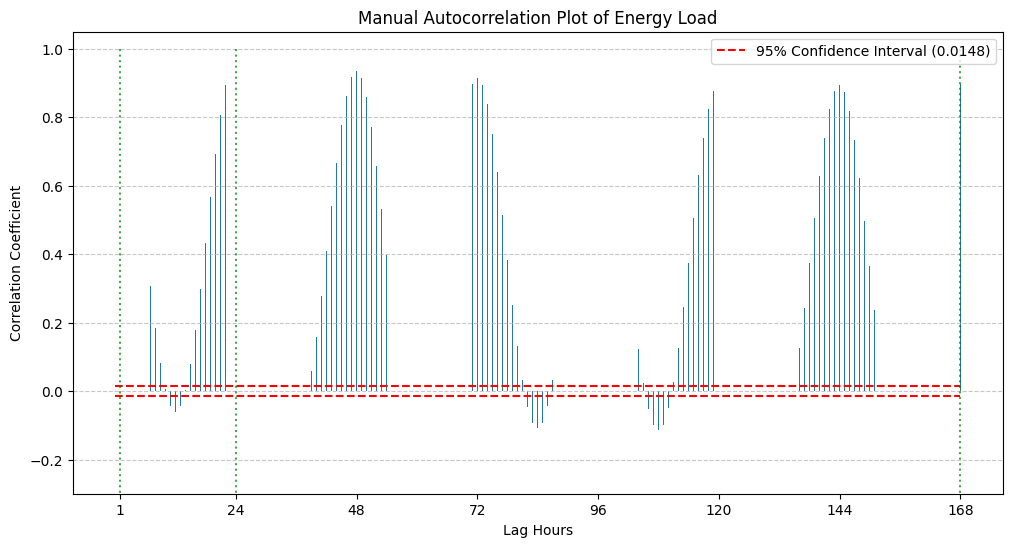

In [95]:
MAX_LAG = 168
autocorr_values = []
lags = range(1, MAX_LAG + 1)

for lag in lags:
    lagged_load = merged_data['load'].shift(lag)
    correlation = merged_data['load'].corr(lagged_load)

    autocorr_values.append(correlation)

plt.figure(figsize=(12,6))
plt.bar(lags, autocorr_values, width=0.1, color='tab:blue')

N = len(merged_data)
ci = 1.96 / np.sqrt(N)
plt.hlines(ci, 0, MAX_LAG, color='red', linestyle='--', label=f'95% Confidence Interval ({ci:.4f})')
plt.hlines(-ci, 0, MAX_LAG, color='red', linestyle='--')

key_lags = [1,24,168]
for lag in key_lags:
    if lag <= MAX_LAG:
        plt.vlines(lag, -1, 1, color='green', linestyle=':', alpha=0.7)

plt.title('Manual Autocorrelation Plot of Energy Load')
plt.xlabel('Lag Hours')
plt.ylabel('Correlation Coefficient')
plt.ylim(-0.3, 1.05)
plt.xticks(np.concatenate(([1], np.arange(24, MAX_LAG + 1, 24))))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()


    

